In [1]:
import keras
import pandas as pd
import tensorflow as tf

2024-11-28 03:31:54.852989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 03:31:55.206854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732786315.337336    5697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732786315.370592    5697 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 03:31:55.692805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Keras version:  3.6.0
Tensorflow version:  2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_1 = pd.read_csv('mit-bih-data-clear-data.csv')
data_2 = pd.read_csv('ptb-diagnostic-clear-data.csv')
data_3 = pd.read_csv('autonomic-aging-a-dataset-clear-data.csv')


# Feature cleanup
df = pd.concat([data_1, data_2, data_3], ignore_index=True)

df.value_counts('diagnosis')


diagnosis
0.0    1162
1.0     487
Name: count, dtype: int64

In [4]:
# Take 50 samples of each class and remove them from the original dataframe

class_zero = df[df['diagnosis'] == 0].sample(50)
class_one = df[df['diagnosis'] == 1].sample(50)

df = df.drop(class_zero.index)
df = df.drop(class_one.index)

In [5]:
df.value_counts('diagnosis')

diagnosis
0.0    1112
1.0     437
Name: count, dtype: int64

In [6]:
class_zero.to_csv('virgin_class_zero.csv', index=False)
class_one.to_csv('virgin_class_one.csv', index=False)

In [7]:
# Let's check for missing values

df.isnull().sum()


minimum_hrv               0
maximum_hrv               0
standard_deviation_hrv    0
mean_hr_slope             0
tendency_slope            0
lowest_heart_rate         0
vlf_power                 0
lf_power                  0
hf_power                  0
approximation_entropy     0
diagnosis                 0
dtype: int64

In [8]:
import numpy as np
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']
X_resampled, y_resampled = smote.fit_resample(X, y)

df_upsampled = pd.concat([X_resampled, y_resampled], axis=1)




In [9]:
df_upsampled.value_counts('diagnosis')


diagnosis
0.0    1112
1.0    1112
Name: count, dtype: int64

In [10]:
#Uncomment to check Pairplot
# import seaborn as sns
# sns.set_theme(style='ticks')

# sns.pairplot(df_upsampled, hue='diagnosis', kind='kde', corner=True)

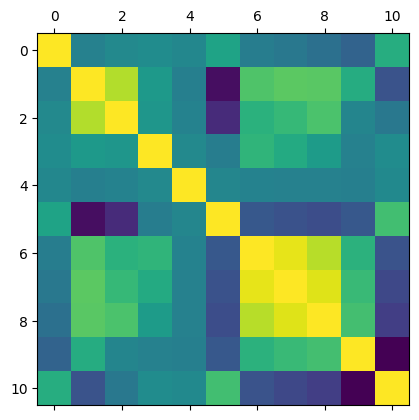

In [11]:
import hr_engine
important_features = [
    'minimum_hrv',
    'maximum_hrv',
    'standard_deviation_hrv',
    'mean_hr_slope',
    'tendency_slope',
    'lowest_heart_rate',
    'vlf_power',
    'lf_power',
    'hf_power',
    'approximation_entropy'
]
from sklearn.impute import SimpleImputer
target = 'diagnosis'

features = df_upsampled[important_features]
# features.replace([np.inf, -np.inf], np.nan, inplace=True)
# imputer = SimpleImputer(strategy='median')

from sklearn.preprocessing import StandardScaler
import joblib

# scaler = StandardScaler()
# features = imputer.fit_transform(features)
# features = scaler.fit_transform(features)
# joblib.dump(scaler, 'scaler.pkl')

features = hr_engine.scale_for_training(features)

df = pd.DataFrame(features, columns=important_features)

df[target] = df_upsampled[target]

df.to_csv('heart_rate_final_data.csv', index=False)

import matplotlib.pyplot as plt
plt.matshow(df.corr())
plt.show()

In [12]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X.head()

,minimum_hrv,maximum_hrv,standard_deviation_hrv,mean_hr_slope,tendency_slope,lowest_heart_rate,vlf_power,lf_power,hf_power,approximation_entropy
0,5.427997,-1.118094,-0.864461,-0.079877,-0.074993,4.254860,-0.283061,-0.187206,-0.244514,0.529988
1,3.372288,-0.789848,-0.755763,-0.064178,-0.073900,2.536146,0.506203,0.381267,-0.014904,0.265355
2,1.404907,-0.755984,-0.694422,0.052389,-0.046179,0.584531,1.998228,0.696894,-0.102124,0.317599
3,1.918801,-1.107245,-0.857760,0.005427,-0.037572,1.221284,0.434447,-0.140292,-0.263848,0.146128
4,0.213788,-1.305044,-0.980049,-0.081524,-0.016458,-0.949551,-0.115790,-0.414761,-0.487304,0.845448


In [13]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [14]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

I0000 00:00:1732786322.960406    5697 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21465 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Training fold 0...


I0000 00:00:1732786325.785770    6141 service.cc:148] XLA service 0x7670a4017420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732786325.786053    6141 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-28 03:32:05.862356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732786326.062901    6141 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732786327.656492    6141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-28 03:32:10.650388: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_85_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-28 03:32:10.778487: I external/l

 1/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step

2024-11-28 03:36:53.921135: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 120 bytes spill stores, 120 bytes spill loads

2024-11-28 03:36:53.963741: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-28 03:36:54.021659: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51_0', 352 bytes spill stores, 448 bytes spill loads

2024-11-28 03:36:54.084266: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 03:36:54.099860: I external/local_xla/xla/stream_

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step
Fold 0
Confusion Matrix:
 [[146  10]
 [  1 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       156
         1.0       0.94      0.99      0.97       156

    accuracy                           0.96       312
   macro avg       0.97      0.96      0.96       312
weighted avg       0.97      0.96      0.96       312



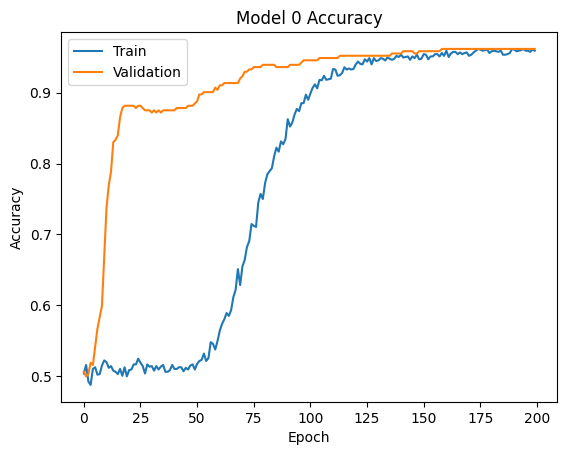

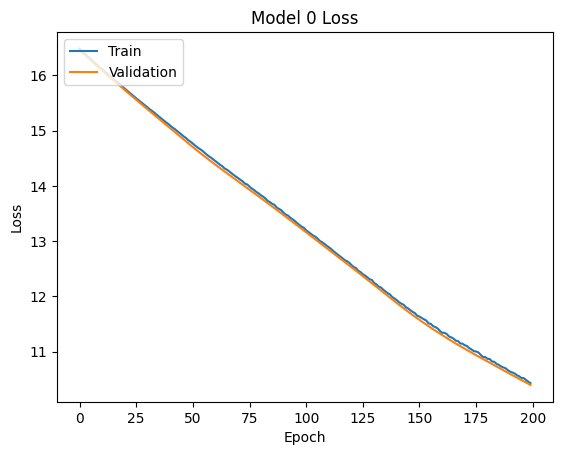

Training fold 1...


2024-11-28 03:36:58.909628: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63_0', 828 bytes spill stores, 1256 bytes spill loads

2024-11-28 03:36:58.917463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_81_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-28 03:36:59.242965: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 220 bytes spill stores, 220 bytes spill loads

2024-11-28 03:36:59.471001: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 4 bytes spill stores, 4 bytes spill loads



 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-11-28 03:41:45.502727: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 104 bytes spill stores, 104 bytes spill loads

2024-11-28 03:41:45.505138: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 03:41:45.527180: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 104 bytes spill stores, 104 bytes spill loads

2024-11-28 03:41:45.528384: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-28 03:41:45.528439: I external/local_xla/xla/stream_ex

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step
Fold 1
Confusion Matrix:
 [[142  14]
 [  0 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95       156
         1.0       0.92      1.00      0.96       155

    accuracy                           0.95       311
   macro avg       0.96      0.96      0.95       311
weighted avg       0.96      0.95      0.95       311



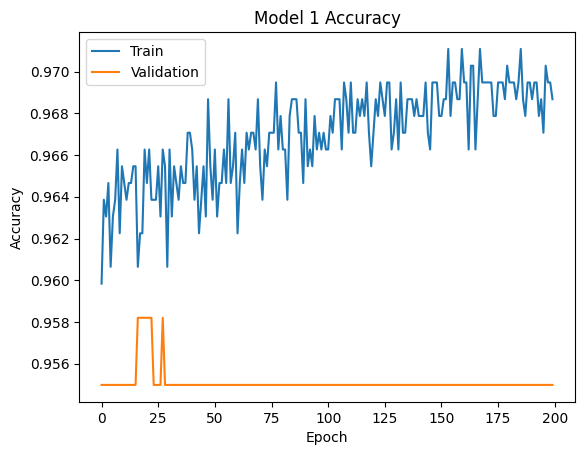

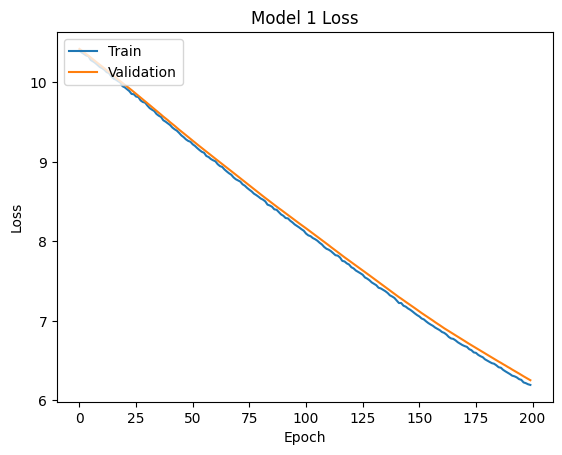

Training fold 2...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
Fold 2
Confusion Matrix:
 [[145  11]
 [  2 153]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       156
         1.0       0.93      0.99      0.96       155

    accuracy                           0.96       311
   macro avg       0.96      0.96      0.96       311
weighted avg       0.96      0.96      0.96       311



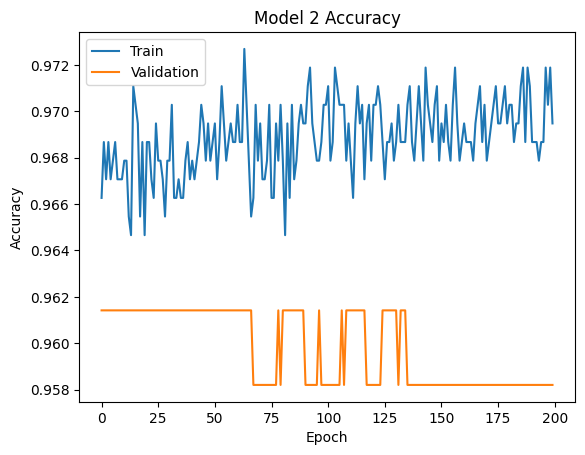

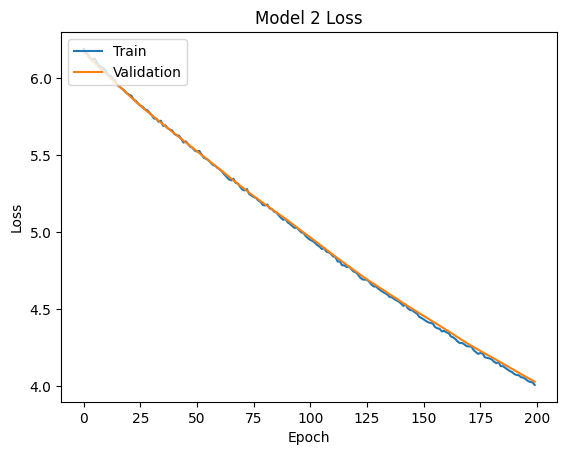

Training fold 3...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
Fold 3
Confusion Matrix:
 [[145  10]
 [  1 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       155
         1.0       0.94      0.99      0.97       156

    accuracy                           0.96       311
   macro avg       0.97      0.96      0.96       311
weighted avg       0.97      0.96      0.96       311



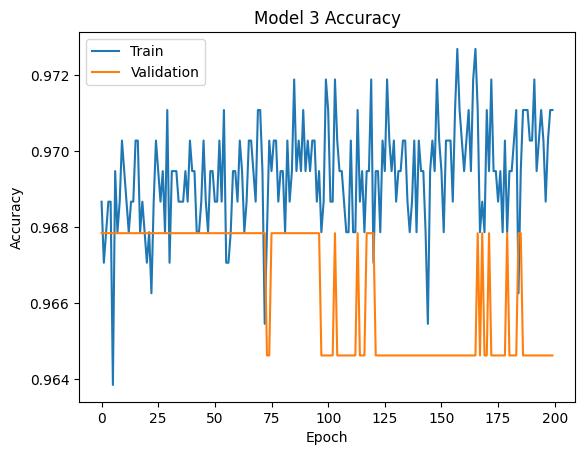

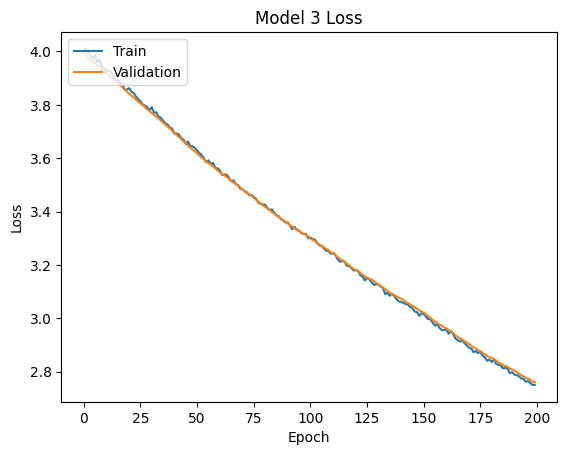

Training fold 4...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
Fold 4
Confusion Matrix:
 [[153   2]
 [  1 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       155
         1.0       0.99      0.99      0.99       156

    accuracy                           0.99       311
   macro avg       0.99      0.99      0.99       311
weighted avg       0.99      0.99      0.99       311



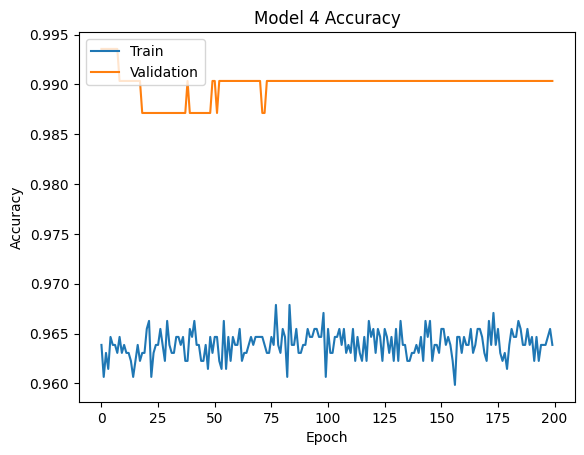

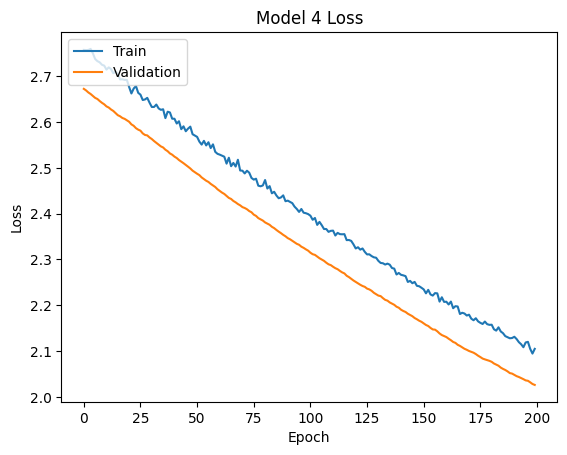

In [15]:
from keras import Sequential, Input
from keras.api.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l1, l2


accuracy_scores = []
i = 0

def create_model():
    l1_regulizer = l1(0.0001)
    l2_regulizer = l2(0.0001)

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(8192, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.7),
        Dense(4096, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.6), 
        Dense(2048, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.4),
        Dense(512, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.api.optimizers.Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
initial_weights = model.get_weights()

for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print(f'Training fold {fold}...')

    if fold > 0:
        model.set_weights(previous_weights)


    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]


    from keras.api.callbacks import ModelCheckpoint, EarlyStopping
    checkpoint = ModelCheckpoint(f'model_{i}.keras', save_best_only=True)
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=8, verbose=0, callbacks=[checkpoint, early_stopping], validation_data=(X_test_fold, y_test_fold))
    previous_weights = model.get_weights()

    # Evaluate the model
    y_pred = (model.predict(X_test_fold) > 0.6).astype("int32")
    accuracy = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(accuracy)

    cm = confusion_matrix(y_test_fold, y_pred)
    cr = classification_report(y_test_fold, y_pred)
    print(f"Fold {i}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)


    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model {i} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model {i} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    i += 1

In [16]:
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")


Mean Accuracy: 0.9666
Standard Deviation of Accuracy: 0.0125
